In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("cleaned_data.csv")

C:\Users\madsh\AppData\Local\Temp\ipykernel_13508\1136404764.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("cleaned_data.csv")


In [4]:
loan_id_mapping = {id: index for index, id in enumerate(data['Loan ID'].unique())}
customer_id_mapping = {id: index for index, id in enumerate(data['Customer ID'].unique())}

# Replace the IDs with the mapped integers
data['Loan ID'] = data['Loan ID'].map(loan_id_mapping)
data['Customer ID'] = data['Customer ID'].map(customer_id_mapping)

employment_length_mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

data['Years in current job'] = data['Years in current job'].map(employment_length_mapping)
data['Years of Credit History'] = data['Years of Credit History'].apply(lambda x: float(''.join(c if (str(c).isdigit() or str(c) == '.') else ' ' for c in str(x)).strip()))

data['Monthly Debt'] = data['Monthly Debt'].apply(lambda x: float(''.join(c if (str(c).isdigit() or str(c) == '.') else ' ' for c in str(x)).strip()))


In [5]:
data.to_csv("modelling_data.csv", index=False)

In [17]:
# Define target variable (y) and other varibles (X)
y = data['Loan Status']
X = data.drop(['Loan Status', "Loan ID", "Customer ID", "Current Loan Amount"], axis = 1)

# Split dataset
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

# Show the data split in numbers
shape_dict = {'shape of whole dataset': data.shape, 'shape of train_X': train_X.shape, 'shape of test_X': test_X.shape, 'shape of train_y': train_y.shape, 'shape of test_y': test_y.shape}
for i, v in shape_dict.items(): 
    print(i, v)

shape of whole dataset (42966, 18)
shape of train_X (28787, 14)
shape of test_X (14179, 14)
shape of train_y (28787,)
shape of test_y (14179,)


In [18]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
smote_X, smote_y = sm.fit_resample(train_X, train_y)

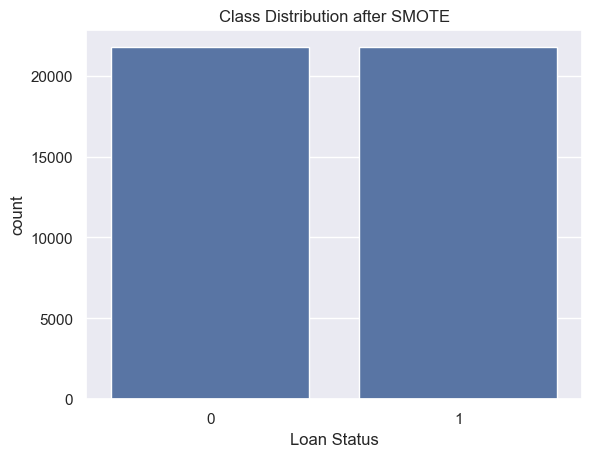

In [19]:
smote_y.value_counts()

# Visualize the resampled class distribution after SMOTE
sns.countplot(x=smote_y)
plt.title("Class Distribution after SMOTE")
plt.show()

# Logistic Regression

In [20]:
clf = LogisticRegression(solver = 'liblinear', random_state=42)
clf.fit(smote_X, smote_y)
pred_y = clf.predict(test_X)
pred_proba_y = clf.predict_proba(test_X)

In [21]:
# Examine the coefficients (the predicted probabilities)
coef = clf.coef_
print(coef)

[[-4.99285016e-06  1.03052881e-03 -9.32389719e-07 -1.13809107e-04
  -2.98063130e-05 -2.20165356e-05  1.48582804e-05 -2.49792022e-04
  -1.47157604e-04 -1.15362390e-05  7.44715723e-07 -4.78286603e-07
  -3.98058343e-06  6.27726258e-07]]


In [22]:
coef_titles = list(X.columns)
coef = pd.DataFrame(clf.coef_.T, columns=['coefficients'], index=coef_titles)
coef

,coefficients
Term,-4.992850e-06
Credit Score,1.030529e-03
Annual Income,-9.323897e-07
Years in current job,-1.138091e-04
Home Ownership,-2.980631e-05
Purpose,-2.201654e-05
Monthly Debt,1.485828e-05
Years of Credit History,-2.497920e-04
Number of Open Accounts,-1.471576e-04
Number of Credit Problems,-1.153624e-05


In [23]:
probability_of_class_1 = pred_proba_y[:, 1]

print("Predicted probability of class 1:", probability_of_class_1)

Predicted probability of class 1: [0.99790089 0.47143848 0.9990249  ... 0.35619915 0.13462014 0.26277661]


In [24]:
print("Classifcation report:\n", classification_report(test_y, pred_y))
print("Confusion matrix:\n", confusion_matrix(test_y, pred_y))


Classifcation report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.75     10690
           1       0.37      0.55      0.44      3489

    accuracy                           0.66     14179
   macro avg       0.60      0.62      0.60     14179
weighted avg       0.71      0.66      0.68     14179

Confusion matrix:
 [[7371 3319]
 [1554 1935]]


In [25]:
data["Loan Status"].value_counts()

Loan Status
0    32443
1    10523
Name: count, dtype: int64

<Figure size 1000x600 with 0 Axes>

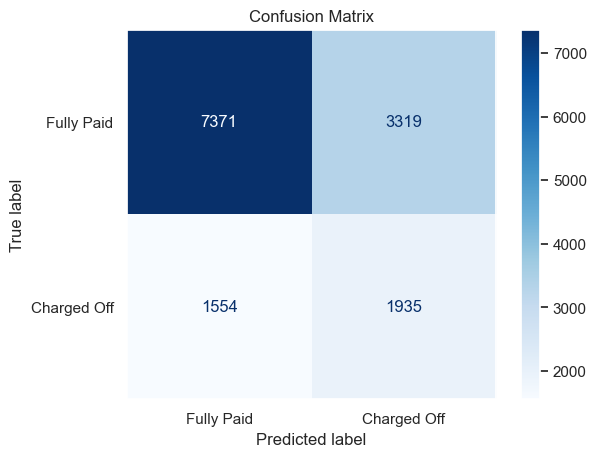

<Figure size 1000x600 with 0 Axes>

In [26]:
cm = confusion_matrix(test_y, pred_y)


labels = ['Fully Paid', 'Charged Off']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.figure(figsize = (10,6))

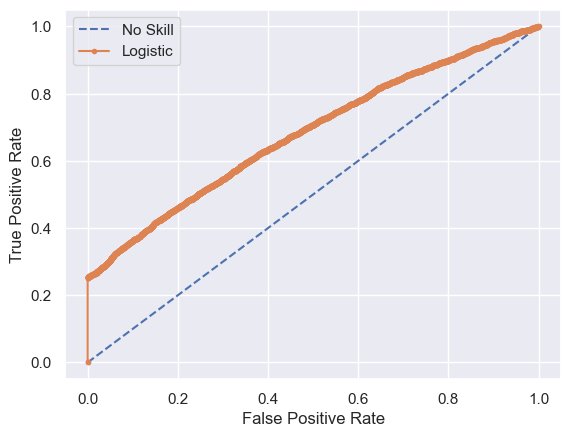

In [27]:
#ROC curve
from sklearn.metrics import roc_curve
from matplotlib import pyplot
pred_proba_y = pred_proba_y[:, 1]
fpr, tpr, thresholds = roc_curve(test_y, pred_proba_y)
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

In [28]:
from sklearn.metrics import roc_auc_score 
auc = roc_auc_score(test_y, pred_proba_y)

auc

0.682075752713124

In [29]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(smote_X, smote_y)
pred_y = dt.predict(test_X)
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     10690
           1       0.42      0.45      0.43      3489

    accuracy                           0.71     14179
   macro avg       0.62      0.62      0.62     14179
weighted avg       0.72      0.71      0.72     14179



In [30]:
print(confusion_matrix(test_y, pred_y))

[[8532 2158]
 [1920 1569]]


<Figure size 1000x600 with 0 Axes>

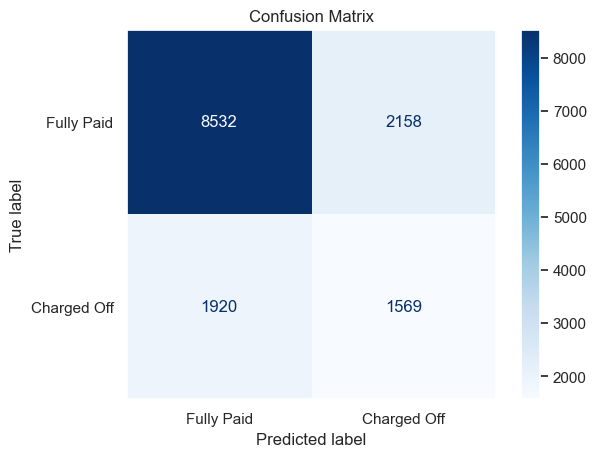

<Figure size 1000x600 with 0 Axes>

In [31]:
cm = confusion_matrix(test_y, pred_y)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['Fully Paid', 'Charged Off']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.figure(figsize = (10,6))

[Ellipsis]

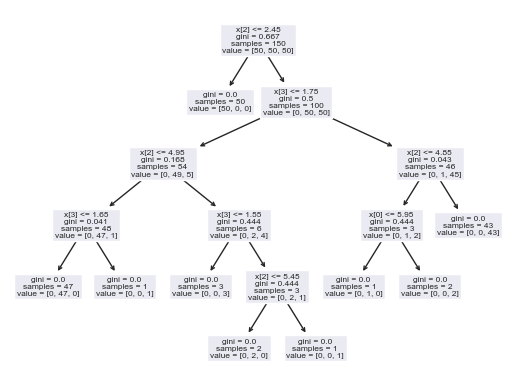

In [32]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X, y)

tree.plot_tree(clf)
[...]

In [33]:
rf = RandomForestClassifier(random_state=42)
rf.fit(smote_X, smote_y)
pred_y = rf.predict(test_X)
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     10690
           1       0.66      0.32      0.43      3489

    accuracy                           0.79     14179
   macro avg       0.74      0.63      0.65     14179
weighted avg       0.77      0.79      0.76     14179



In [34]:
print(confusion_matrix(test_y, pred_y))

[[10121   569]
 [ 2369  1120]]


<Figure size 1000x600 with 0 Axes>

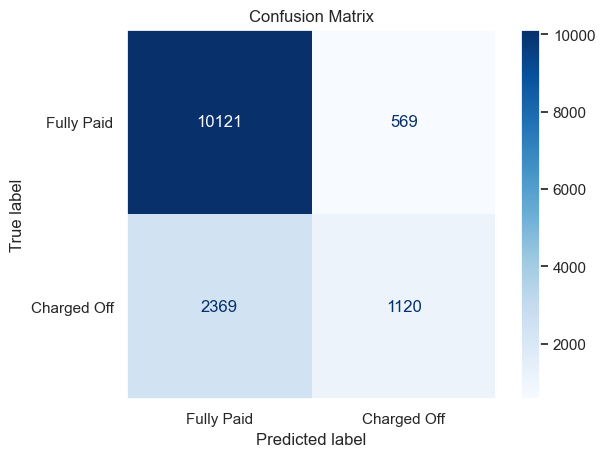

<Figure size 1000x600 with 0 Axes>

In [35]:
cm = confusion_matrix(test_y, pred_y)
labels = ['Fully Paid', 'Charged Off']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
disp.ax_.set_title('Confusion Matrix')
plt.grid(False)
plt.figure(figsize = (10,6))

In [36]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()



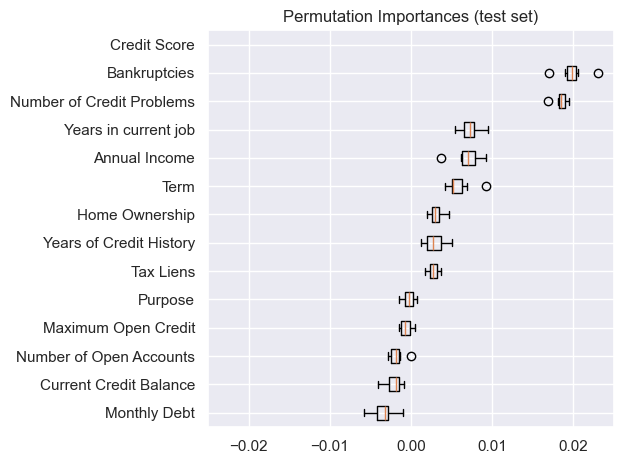

In [37]:
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=test_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
#set xtics to 0.1
plt.xlim(-0.025, 0.025)
fig.tight_layout()